# Trying out an LSTM setup
## Using generated data
### Bi-directional LSTM with adversarial softmax layer

In [1]:
import numpy as np
import gym

def cart_pole(observation):
        
        position, velocity, angle, angle_velocity = observation
        action = int(3. * angle + angle_velocity > 0.)
        return action
        
def mountain_car(observation):

    position, velocity = observation
    lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
            0.3 * (position + 0.9) ** 4 - 0.008)
    ub = -0.07 * (position + 0.38) ** 2 + 0.07
    end = position > 0.2 and velocity > 0.02
    hard_end = position > 0.45
    begin = position < -0.45 and velocity < 0.001 and velocity > -0.001
    if begin or (lb < velocity < ub) or end or hard_end:
        action = 2 
    else:
        action = 0
    return action

class Expert(object):
        
    
    def __init__(self, env_name):
        
        policies = {
            'CartPole-v0': cart_pole,
            'MountainCar-v0': mountain_car
        }
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.policy = policies[env_name]
        
    def generate_data(self, num_episodes=1):

        trajectories = []
        rewards = []
        splits = []
        counter = 0
        for i in range(num_episodes):


            observation = self.env.reset()
            done = False
            rd = 0
            
            while not done:

                action = self.policy(observation)
                trajectories.append(
                    [
                        feature for feature in observation
                    ] + [action] + [i]
                )
                observation, reward, done, _ = self.env.step(action)
                rd += reward
                counter += 1
            
            rewards.append(rd)
            splits.append(counter)
                
        return np.array(trajectories), np.mean(rewards), splits

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Generate data

In [3]:

expert = Expert('MountainCar-v0')
NUMBER_OF_EPISODES = 100
data, avg_reward, splits = expert.generate_data(NUMBER_OF_EPISODES)
avg_reward, data.shape

(-100.75, (10075, 4))

### Plot expert data

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

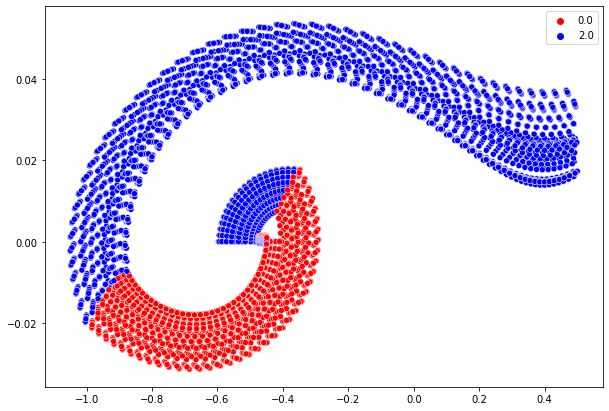

In [5]:
colors = np.array(['red', 'green', 'blue'])
palette = colors[np.unique(data[:,2]).astype(int)].tolist()

fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=data[:,2], palette=palette)

### Preprocess data into sequences

In [22]:
X_partitioned = np.split(data, splits)[0:NUMBER_OF_EPISODES]
max_len = np.max([len(x) for x in X_partitioned])
# for i in range(len(X_partitioned)):

#   for j in range(len(X_partitioned[i])):

#     X_partitioned.append(X_partitioned[i][0:j])

X_partitioned_test = np.split(data, splits)[0:NUMBER_OF_EPISODES]
max_len

138

In [23]:
import torch
torch.cuda.CUDA_LAUNCH_BLOCKING=1
device = torch.device('cpu')

In [24]:
def seq_to_x(seq, pad_to):
    
    return [
            [seq[i][0], seq[i][1], seq[i-1][0] if i > 0 else 0, seq[i-1][1] if i > 0 else 0,  int(i==0), 0] if i < len(seq) 
            else [99, 99, 99, 99, 0, 1]
            for i in range(pad_to)
        ]

def seq_to_target(seq, pad_to):
    
    return [
            seq[i][2] if i < len(seq) else 1 for i in range(pad_to)
        ]


def training_X(data, max_len):
    
    return torch.tensor(
        np.array(
            [
                seq_to_x(seq, max_len) for seq in data
            ],
            dtype=np.float
        ),
        dtype=torch.float
    )

def training_Y(data, max_len):
    
    return torch.tensor(
        [
            seq_to_target(seq, max_len) for seq in data
        ],
        dtype=torch.long
    )

def true_indicies(Y):
    
    true = []
    for i in range(Y.shape[0]):
        
        if Y[i] == 0 or Y[i] == 2:
            true.append(i)
    
    return true

In [25]:
X = training_X(X_partitioned, max_len).to(device)
X_test = training_X(X_partitioned_test, max_len).to(device)

In [26]:
Y = torch.unsqueeze(training_Y(X_partitioned, max_len), dim=2).to(device)
Y_test = training_Y(X_partitioned, max_len)
true = true_indicies(Y_test.view(-1))
torch.unique(Y)

tensor([0, 1, 2])

In [27]:
torch.randn((5, 2, 6))[:,:,0:-1].shape

torch.Size([5, 2, 5])

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class PolicyMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, target_size):
        
        super(PolicyMLP, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, target_size)
        self.output = nn.Softmax(dim=2)
        
    def forward(self, batch):
        
        linear_out = self.relu(self.linear1(batch))
        #linear_out = batch
        #print(linear_out.shape)
        out = self.output(self.linear2(linear_out))
        #print(out.shape)
        return out
    
    def predict(self, X):
        
        with torch.no_grad():
            pred = self.forward(X)
        
        return torch.argmax(pred, dim=2).view(-1)

model = PolicyMLP(6, 10, 3).to(device)

In [29]:
def train(xdata, ydata, model, n_epochs, lr=0.01, print_every=100):
    '''Train the neural model with the given training data'''

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 


    for epoch in range(n_epochs):
        
        model.zero_grad()
        
        Y_pred = model(xdata)
        
        #print(Y_pred.view(-1, 2).shape, ydata.view(-1).shape)
        loss = criterion(Y_pred.view(-1, 3), ydata.view(-1))
        
        if epoch % print_every == 0: print('epoch: ', epoch,' loss: ', loss.item()) 
        if loss.item() < 0.10: lr=0.001
        if loss.item() < 0.075: lr=0.0005
        loss.backward()

        optimizer.step()
        
    return model

In [49]:
train(X, Y, model, 200000, lr=1, print_every=10000)

epoch:  0  loss:  0.8675286769866943
epoch:  10000  loss:  0.8674668073654175
epoch:  20000  loss:  0.8674082159996033
epoch:  30000  loss:  0.8673497438430786
epoch:  40000  loss:  0.867290735244751
epoch:  50000  loss:  0.8672336935997009
epoch:  60000  loss:  0.8671788573265076
epoch:  70000  loss:  0.8671258687973022
epoch:  80000  loss:  0.8670734763145447
epoch:  90000  loss:  0.867023766040802
epoch:  100000  loss:  0.8669742941856384
epoch:  110000  loss:  0.8669260144233704
epoch:  120000  loss:  0.8668803572654724
epoch:  130000  loss:  0.866833508014679
epoch:  140000  loss:  0.8667881488800049
epoch:  150000  loss:  0.8667440414428711
epoch:  160000  loss:  0.866699755191803
epoch:  170000  loss:  0.866656482219696
epoch:  180000  loss:  0.866614580154419
epoch:  190000  loss:  0.8665734529495239


PolicyMLP(
  (linear1): Linear(in_features=6, out_features=10, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=10, out_features=3, bias=True)
  (output): Softmax(dim=2)
)

In [50]:
preds = model.predict(X_test)[true].cpu()
preds.shape, data.shape

(torch.Size([10075]), (10075, 4))

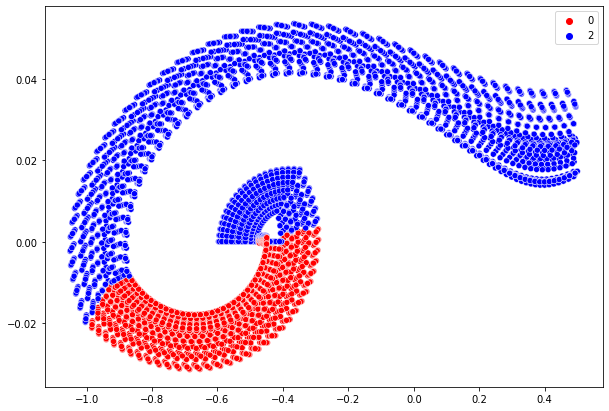

In [51]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.scatterplot(x=data[:,0], y=data[:,1], hue=preds, palette=['red',  'blue'])

In [52]:
env = gym.make('MountainCar-v0')
rewards = []


for i in range(1):

  # print(i)
  observation = env.reset()
  done = False
  rd = 0
  traj = torch.unsqueeze(torch.tensor([[99, 99, 99, 99, 0, 1] for i in range(max_len)], dtype=torch.float), dim=0).to(device)
  traj[0][0] = torch.tensor([ob for ob in observation]+ [99, 99, 1, 0])
  # print(observation)
  while not done:
    
    action = model.predict(traj)
    print(action[-rd].item())
    observation, reward, done, _ = env.step(int(action[-rd].item()))
    rd += int(reward)
    if -rd  >= max_len-1:
      rd = -200
      break
    traj[0][-rd] = torch.tensor([ob for ob in observation] +[traj[0][-rd+1][0], traj[0][-rd+1][1], 0, 0])
   
    #print(traj)

  rewards.append(rd)

np.mean(rewards)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


-200.0